In [6]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.reduction import ReductionSummarizer
from sumy.summarizers.edmundson import EdmundsonSummarizer
from sumy.summarizers.random import RandomSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
import os
import math
import sentencepiece
import evaluate
from transformers import pipeline, AutoTokenizer
import datasets
import pandas as pd
import numpy as np
import textwrap
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import requests
from bs4 import BeautifulSoup
import rouge
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
import re
import difflib
import contractions  
import gensim
import pickle
import asyncio
import nest_asyncio
nest_asyncio.apply()
from requests_html import AsyncHTMLSession
asession = AsyncHTMLSession()
rouge = evaluate.load('rouge')
bertscore = evaluate.load("bertscore")

from vizualization import utils_split_sentences, display_string_matching

/usr/local/Caskroom/miniconda/base/envs/1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/Viktor_Shevchuk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Viktor_Shevchuk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Viktor_Shevchuk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/Viktor_Shevchuk/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
def save_auto_generated_summaries(model_name, summary_list):
    folder_name = model_name + "_summarized"
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)

    for index, auto_generated_summary in enumerate(summary_list):
        file_path = os.path.join(folder_name, str(index) + ".txt")
        with open(file_path, 'w') as file:
            file.write(auto_generated_summary)

In [167]:
def evaluate_summary(reference, predicted):
    predictions = [predicted]
    references = [reference]
    results = rouge.compute(predictions=predictions, references=references, rouge_types=['rouge1', 'rouge2', 'rougeL'])
    score_1 = round(results['rouge1'], 2)
    score_2 = round(results['rouge2'], 2)
    score_L = round(results['rougeL'], 2)

    avg_rouge = round(np.mean([score_1, score_2, score_L]), 2)
    print("rouge1:", score_1, "| rouge2:", score_2, "| rougeL:", score_L, "--> avg rouge:", avg_rouge)

    return { "score_1": score_1, "score_2": score_2, "score_L": score_L, "avg_rouge": avg_rouge }

In [5]:
URL1 = "https://zakon.rada.gov.ua/laws/show/en/1207-18/conv/print"
URL2 = "https://zakon.rada.gov.ua/laws/show/en/1700-18/print"
URL3 = "https://zakon.rada.gov.ua/laws/show/en/254%D0%BA/96-%D0%B2%D1%80/print"
page = requests.get(URL1)

# print(page.text)

In [ ]:
page.content

In [ ]:
soup = BeautifulSoup(page.content, "html.parser")
# soup

In [ ]:
paragraphs = soup.select('.rvts0 > .rvps2')
paragraphs

In [ ]:
legal_stop_words = [
    "amended", "restated", "be stated", "supplemented", "section", "paragraph", "article", "as follows"
]

In [ ]:
def is_sentence_with_stopWord(para):
    for word in legal_stop_words:
        sentence_with_stopWord = para.find(
            text=lambda t: word in t.text.lower()
        )

        if sentence_with_stopWord:
            return True

In [ ]:
def is_provisions(para):
    pattern = r"\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?"
    para_with_no_roman = re.sub(pattern, '', para.text.strip()).strip()

    return para_with_no_roman == "Final and transitional provisions"

In [ ]:
def is_article_ensuring(para):
  return para.find("span", class_="rvts37")

In [ ]:
def is_article_title(para):
    return para.find("span", class_="rvts9")

In [ ]:
def is_closing_char(letter):
  return letter == "." or letter == ")"

In [ ]:
def discard_ordered_list_numbers(text):
    is_first_char_numeric = text[0].isdigit()
    is_second_char_numeric = text[1].isdigit()
    is_third_char_numeric = text[2].isdigit()

    if is_first_char_numeric and is_closing_char(text[1]):
        return text[2:].strip()
    elif is_first_char_numeric and is_second_char_numeric and is_closing_char(text[2]):
        return text[3:].strip()
    elif is_first_char_numeric and is_second_char_numeric and is_third_char_numeric and is_closing_char(text[3]):
        return text[4:].strip()
    elif re.search(r"[a-z]", text[0]) and is_closing_char(text[1]):
        return text[2:].strip()

    return text

In [ ]:
def is_sentence_end(sentence):
    last_character = sentence[-1]
    is_etc = sentence[-4:] == "etc."

    if last_character == "." and not is_etc:
        return True
    else:
        return False

In [ ]:
def clean(paragraphs):
    cleaned = []
    article_ensuring = False
    concatenated_list = []
    ordered_list_with_stop_word = False

    for para in paragraphs:
        if article_ensuring and not is_article_title(para):
            continue
        elif article_ensuring and is_article_title(para):
            article_ensuring = False

        if is_article_ensuring(para):
            article_ensuring = True
            continue

        if is_provisions(para):
            return cleaned

        if is_article_title(para):
            continue

        text = para.text.strip()
        last_character = text[-1]

        if is_sentence_with_stopWord(para) and last_character == ":":
            ordered_list_with_stop_word = True
        elif not is_sentence_with_stopWord(para) and ordered_list_with_stop_word and is_sentence_end(text):
            ordered_list_with_stop_word = False
        elif not is_sentence_with_stopWord(para) and not ordered_list_with_stop_word:
            if last_character == ":" and not len(concatenated_list):
                concatenated_list.append(text)
            elif len(concatenated_list) and not is_sentence_end(text):
                concatenated_list.append(text)
            elif is_sentence_end(text) and len(concatenated_list):
                concatenated_list.append(text)
                cleaned.append(
                    discard_ordered_list_numbers(" ".join(concatenated_list))
                )
                concatenated_list.clear()
            elif not len(concatenated_list):
                cleaned.append(discard_ordered_list_numbers(text))

    return cleaned

In [ ]:
cleaned_paragraphs = sent_tokenize(' '.join(clean(paragraphs)))
cleaned_paragraphs

In [ ]:
stop_words = set(stopwords.words('english'))
type(stop_words)

In [ ]:
stop_words.add('shall')
stop_words.add('.')
stop_words.add(',')
stop_words.add('(')
stop_words.add(')')
stop_words.add(';')
stop_words.add(':')
stop_words.add('—')
stop_words.add('-')

In [ ]:
word_tokens = nltk.word_tokenize(" ".join(cleaned_paragraphs))

In [ ]:
# converts the words in word_tokens to lower case and then checks whether they are present in stop_words or not
filtered_sentence = [w.lower()
                     for w in word_tokens if not w.lower() in stop_words]
# with lower case conversion

In [ ]:
'''
Compute n-grams frequency with nltk tokenizer.
:parameter
    :param corpus: list - dtf["text"]
    :param ngrams: int or list - 1 for unigrams, 2 for bigrams, [1,2] for both
    :param top: num - plot the top frequent words
:return
    dtf_count: dtf with word frequency
'''


def word_freq(corpus, ngrams=[1, 2, 3], top=10, figsize=(10, 7)):
    lst_tokens = nltk.tokenize.word_tokenize(corpus)
    ngrams = [ngrams] if type(ngrams) is int else ngrams

    # calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(),
                             columns=["word", "freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(
        lambda x: " ".join(string for string in x))
    dtf_freq = dtf_freq.sort_values(
        ["ngrams", "freq"], ascending=[True, False])

    # plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')[
                    "ngrams", "freq", "word"].head(top)
                )
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq

In [ ]:
# Find most common words in text
freq = word_freq(
    corpus=" ".join(filtered_sentence),
    ngrams=[1],
    top=45,
    figsize=(10, 8)
)

In [ ]:
tokened_sent = sent_tokenize(" ".join(cleaned_paragraphs))

main_dict = {}

for item in tokened_sent:
    item1 = list(item.split(" "))
    item2 = [' '.join(item1)]
    Length = []
    Length.append(len(item1))
    mydict = dict(zip(item2, Length))
    main_dict.update(mydict)

print('Maximum word amount in a sentence: ', max(main_dict.values()))
print('Minimum word amount in a sentence: ', min(main_dict.values()))
print('Average word amount in a sentence: ', mean(main_dict.values()))

In [ ]:
featurizer = TfidfVectorizer(
    stop_words=stopwords.words('english'), 
    # norm='l1'
)
# featurizer

In [ ]:
X = featurizer.fit_transform(
    cleaned_paragraphs
)
# X

In [ ]:
def get_sentence_score(tfidf_row):
    # return the average of the non-zero values of the tf-idf vector representation of a sentence
    x = tfidf_row[tfidf_row != 0]

    return x.mean()

In [ ]:
scores = np.zeros(len(cleaned_paragraphs))
for i in range(len(cleaned_paragraphs)):
    score = get_sentence_score(X[i, :])
    scores[i] = score

In [ ]:
sort_idx = np.argsort(-scores)
# sort_idx

In [ ]:
for i in sort_idx[:20]:
    print("%.2f: %s" % (scores[i], cleaned_paragraphs[i]))

In [ ]:
# title = soup.find("span", class_="rvts23").text 
# title

In [ ]:
def tf_idf_summarize(text):
    X = featurizer.fit_transform(text)
    scores = np.zeros(len(text))

    for i in range(len(text)):
        score = get_sentence_score(X[i, :])
        scores[i] = score

    sort_idx = np.argsort(-scores)
  
    summarized = ""

    for i in sort_idx[:10]:
        test = text[i]
        summarized += text[i] + " "

    return summarized.strip()

In [ ]:
tf_idf_summarize(cleaned_paragraphs)

LexRank Algorithm is an unsupervised approach to summarization and is inspired by the PageRank algorithm. LexRank uses an IDF-modified cosine similarity score to improve the Pagerank score for document summarization. It summarizes the text based on graph-based centrality scoring of sentences.

If one sentence is very similar to other sentences in the text corpus, then that sentence is considered of great importance. Such sentences can be recommended to the users.

In [ ]:
S = cosine_similarity(X)
# S

In [ ]:
S.shape

In [ ]:
len(cleaned_paragraphs)

In [ ]:
# normalize similarity matrix
S /= S.sum(axis=1, keepdims=True)

In [ ]:
S[0].sum()

In [ ]:
# uniform transition matrix
U = np.ones_like(S) / len(S)

In [ ]:
U[0].sum()

In [ ]:
# smoothed similarity matrix
factor = 0.15 
S = (1 - factor) * S + factor * U

In [ ]:
S[0].sum()

In [ ]:
# find the limiting / stationary distribution
eigenvals, eigenvecs = np.linalg.eig(S.T)

In [ ]:
# eigenvals

In [ ]:
# eigenvecs[:, 0]


In [ ]:
# eigenvecs[:, 0].dot(S)

In [ ]:
scores = eigenvecs[:, 0] / eigenvecs[:, 0].sum()
sort_idx = np.argsort(-scores)

In [ ]:
for i in sort_idx[:10]:
    print("%.2f: %s" % (scores[i], cleaned_paragraphs[i]))

In [ ]:
def textRankSummarize(text, factor=0.15):
    X = featurizer.fit_transform(text)
    S = cosine_similarity(X)  # compute similarity matrix
    S /= S.sum(axis=1, keepdims=True)  # normalize similarity matrix
    U = np.ones_like(S) / len(S)  # uniform transition matrix
    S = (1 - factor) * S + factor * U  # smooth similarity matrix
    # find the limiting / stationary distribution
    eigenvals, eigenvecs = np.linalg.eig(S.T)
    scores = eigenvecs[:, 0] / eigenvecs[:, 0].sum()  # compute scores
    sort_idx = np.argsort(-scores)  # sort scores

    summarized = ""

    for i in sort_idx[:10]:
        test = text[i]
        summarized += text[i] + " "

    return summarized.strip()

In [ ]:
textRankSummarize(cleaned_paragraphs)

In [ ]:
from sumy.summarizers.lsa import LsaSummarizer

In [ ]:
parser = PlaintextParser.from_string(cleaned_paragraphs, Tokenizer("english"))
parser 

In [ ]:
summarizer = LsaSummarizer()
summarizer

In [ ]:
summary = summarizer(parser.document, sentences_count=10)
# summary
[str(sentence) for sentence in summary]

In [ ]:
# Luhn
from sumy.summarizers.luhn import LuhnSummarizer
# text: text to summarize
# no_sentences: number of sentences in your summary,
# lang: language of text


def luhn_summary(text, no_sentences, lang):
    parser = PlaintextParser(text, Tokenizer(lang))
    luhn_sum = LuhnSummarizer()
    summary = luhn_sum(parser.document, no_sentences)
    return [str(sentence) for sentence in summary]

In [ ]:
luhn_summary(cleaned_paragraphs, 10, "english")

In [ ]:
# KL
from sumy.summarizers.kl import KLSummarizer
# text: text to summarize
# no_sentences: number of sentences in your summary,
# lang: language of text


def kl_summary(text, no_sentences, lang):
    parser = PlaintextParser.from_string(text, Tokenizer(lang))
    kl_summarizer = KLSummarizer()
    summary = kl_summarizer(parser.document, sentences_count=no_sentences)
    return [str(sentence) for sentence in summary]

In [ ]:
kl_summary(cleaned_paragraphs, 10, "english")

TextRank vs Seq2Seq vs BART

The hardest NLP tasks are the ones where the output isn’t a single label or value (like Classification and Regression), but a full new text (like Translation, Summarization and Conversation).

Text summarization is the problem of reducing the number of sentences and words of a document without changing its meaning. There are different techniques to extract information from raw text data and use it for a summarization model, overall they can be categorized as Extractive and Abstractive. Extractive methods select the most important sentences within a text (without necessarily understanding the meaning), therefore the result summary is just a subset of the full text. On the contrary, Abstractive models understand the semantics of the text and generate a meaningful summary. 

I’ll keep On Ensuring Civil Rights and Freedoms, and the Legal Regime on the Temporarily Occupied Territory of Ukraine summary on dentons to compare different models.

How can we evaluate the results? 

In [ ]:
evaluate_summary(
    human_summary,
    tf_idf_summarize(cleaned_paragraphs)
)

The results show that 22% of unigrams (ROUGE-1) and 7% of bigrams (ROUGE-2) are present in both summaries, while the longest common subsequences (ROUGE-L) match by 7%. Overall, the average score is 16%. ROUGE scores don’t measure how fluent the summary is. For that experts recomend using the good old human eye. 

In [ ]:
evaluate_summary(
    human_summary,
    textRankSummarize(cleaned_paragraphs)
)

Visualization: I will display 2 texts, i.e. the summary and the original text, or the predicted summary and the real summary, and highlight the matching parts. It highlights the matching substrings of two texts. It can be used on word-level.

In [ ]:
'''
Find the matching substrings in 2 strings.
:parameter
    :param a: string - raw text
    :param b: string - raw text
:return
    2 lists used in to display matches
'''


def utils_split_sentences(a, b):
    # find clean matches
    match = difflib.SequenceMatcher(isjunk=None, a=a, b=b, autojunk=True)
    lst_match = [block for block in match.get_matching_blocks()
                 if block.size > 20]

    # difflib didn't find any match
    if len(lst_match) == 0:
        lst_a, lst_b = sent_tokenize(a), sent_tokenize(b)

    # work with matches
    else:
        first_m, last_m = lst_match[0], lst_match[-1]

        # a
        string = a[0: first_m.a]
        lst_a = [t for t in sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = a[m.a: m.a+m.size]
            lst_a.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = a[m.a+m.size: next_m.a]
                lst_a = lst_a + [t for t in sent_tokenize(string)]
            else:
                break
        string = a[last_m.a+last_m.size:]
        lst_a = lst_a + [t for t in sent_tokenize(string)]

        # b
        string = b[0: first_m.b]
        lst_b = [t for t in sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = b[m.b: m.b+m.size]
            lst_b.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = b[m.b+m.size: next_m.b]
                lst_b = lst_b + [t for t in sent_tokenize(string)]
            else:
                break
        string = b[last_m.b+last_m.size:]
        lst_b = lst_b + [t for t in sent_tokenize(string)]

    return lst_a, lst_b

'''
Highlights the matched strings in text.
:parameter
    :param a: string - raw text
    :param b: string - raw text
    :param both: bool - search a in b and, if True, viceversa
    :param sentences: bool - if False matches single words
:return
    text html, it can be visualized on notebook with display(HTML(text))
'''


def display_string_matching(a, b, both=True, sentences=True, titles=[]):
    if sentences is True:
        lst_a, lst_b = utils_split_sentences(a, b)
    else:
        lst_a, lst_b = a.split(), b.split()

    # highlight a
    first_text = []
    for i in lst_a:
        if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_b]:
            first_text.append(
                '<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
        else:
            first_text.append(i)
    first_text = ' '.join(first_text)

    # highlight b
    second_text = []
    if both is True:
        for i in lst_b:
            if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_a]:
                second_text.append(
                    '<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
            else:
                second_text.append(i)
    else:
        second_text.append(b)
    second_text = ' '.join(second_text)

    # concatenate
    if len(titles) > 0:
        first_text = "<strong>"+titles[0]+"</strong><br>"+first_text
    if len(titles) > 1:
        second_text = "<strong>"+titles[1]+"</strong><br>"+second_text
    else:
        second_text = "---"*65+"<br><br>"+second_text
    final_text = first_text + '<br><br>' + second_text
    return final_text

In [ ]:
match = display_string_matching(
    human_summary,
    tf_idf_summarize(cleaned_paragraphs),
    both=True,
    sentences=False,
    titles=["Real Summary", "tfIDF Predicted Summary"]
)

In [ ]:
# display(HTML(match))

In [ ]:
match = display_string_matching(
    human_summary,
    textRankSummarize(cleaned_paragraphs),
    both=True,
    sentences=False,
    titles=["Real Summary", "Text Rank Predicted Summary"]
)

In [ ]:
# display(HTML(match))

In [ ]:
match = display_string_matching(
    ' '.join(cleaned_paragraphs),
    tf_idf_summarize(cleaned_paragraphs),
    both=True,
    titles=["Full Text", "tfIDF Predicted Summary"]
)

# display(HTML(match))

In [ ]:
match = display_string_matching(
    ' '.join(cleaned_paragraphs),
    textRankSummarize(cleaned_paragraphs),
    both=True,
    titles=["Full Text", "Text Rank Predicted Summary"]
)

# display(HTML(match))

The prediction has most of the information mentioned in the original summary. As expected from an Extractive algorithms, the predicted summary is fully contained in the text: the model considers those the most important sentences.

For our purposes in this chapter, we can
also use the tokenizers from NLTK to build a simple text summarizer that is based on
Luhn's method that he wrote about in The automatic creation of literature abstracts. This
basic, extractive program will first tokenize each sentence in the text sample, then
choose which words occur most frequently while excluding unimportant words,
called stopwords, and finally it will find the sentence or sentences that include the
important words.


Our program will include one other subtle effect. We will construct a score for each
sentence based on the aggregated scores of the words inside it. For example, suppose
the word cat appears in a text 10 times, and the word hat appears three times. The
sentence The cat wears a hat will score a 13, or the score for cat plus the score for hat.
The sentence His hat is different than her hat will only score 3, since the score for hat is
counted only once. This scoring system has the advantage of privileging sentences
that have a variety of important words in them, while minimizing the effect of
sentences that have fewer important words, even if those words are repeated
multiple times. The rationale for this scoring system is that sentences with a variety
of important words are more likely to be topic sentences or main ideas, and topic
sentences are more relevant for building a summary.


==


In [64]:
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict
import pprint

In [ ]:
text = " ".join(cleaned_paragraphs)
summary_sentences = []
candidate_sentences = {}
candidate_sentence_counts = {}

In [ ]:
words = word_tokenize(text)
# words

In [ ]:
lowercase_words = [word.lower() for word in words
                   if word not in stopwords.words() and word.isalpha()]
lowercase_words

In [ ]:
word_frequencies = FreqDist(lowercase_words)
most_frequent_words = FreqDist(lowercase_words).most_common(25)
most_frequent_words

In [ ]:
sentences = sent_tokenize(text)
for sentence in sentences:
    candidate_sentences[sentence] = sentence.lower()

In [ ]:
for long, short in candidate_sentences.items():
    count = 0
    for freq_word, frequency_score in most_frequent_words:
        if freq_word in short:
            count += frequency_score
            candidate_sentence_counts[long] = count

In [ ]:
sorted_sentences = OrderedDict(sorted(
    candidate_sentence_counts.items(),
    key=lambda x: x[1],
    reverse=True)[:4])
print(sorted_sentences)

Extractive:

In [168]:
LANGUAGE = "english"
stemmer = Stemmer(LANGUAGE)
SENTENCES_COUNT = 7

In [149]:
def make_sum_basic_summarization():
    summarized = []
    summarizer = SumBasicSummarizer()
    summarizer.stop_words = get_stop_words(LANGUAGE)
    for sentence in summarizer(parser.document, SENTENCES_COUNT):
        summarized.append(sentence)

    return ' '.join(str(v) for v in summarized)

In [169]:
def summarize_extractively(law_list, summarizer):
    folder_name = summarizer.__class__.__name__ + "_summarized"
    summarizer.stop_words = get_stop_words(LANGUAGE)

    for index, law in enumerate(law_list):
        file_path = os.path.join(folder_name, str(index) + ".txt")

        summarized = []
        law_text = " ".join(law["cleaned_law"])
        parser = PlaintextParser.from_string(law_text, Tokenizer(LANGUAGE))
        print(index, law["url"])

        for sentence in summarizer(parser.document, SENTENCES_COUNT):
            summarized.append(sentence)
            
        summarized_text = ' '.join(str(v) for v in summarized)
        with open(file_path, 'w') as file:
          file.write(summarized_text)

In [165]:
# summarize_extractively(cleaned_law_list, RandomSummarizer(stemmer))

0 https://zakon.rada.gov.ua/laws/show/en/1669-18
1 https://zakon.rada.gov.ua/laws/show/en/1644-18
2 https://zakon.rada.gov.ua/laws/show/en/1556-18
3 https://zakon.rada.gov.ua/laws/show/en/1207-18
4 https://zakon.rada.gov.ua/laws/show/en/5403-17
5 https://zakon.rada.gov.ua/laws/show/en/5293-17
6 https://zakon.rada.gov.ua/laws/show/en/5073-17
7 https://zakon.rada.gov.ua/laws/show/en/5080-17
8 https://zakon.rada.gov.ua/laws/show/en/5018-17
9 https://zakon.rada.gov.ua/laws/show/en/4901-17
10 https://zakon.rada.gov.ua/laws/show/en/4709-17
11 https://zakon.rada.gov.ua/laws/show/en/4651-17
12 https://zakon.rada.gov.ua/laws/show/en/4572-17
13 https://zakon.rada.gov.ua/laws/show/en/4495-17
14 https://zakon.rada.gov.ua/laws/show/en/3773-17
15 https://zakon.rada.gov.ua/laws/show/en/3715-17
16 https://zakon.rada.gov.ua/laws/show/en/3687-17
17 https://zakon.rada.gov.ua/laws/show/en/3671-17
18 https://zakon.rada.gov.ua/laws/show/en/3392-17
19 https://zakon.rada.gov.ua/laws/show/en/3268-17
20 https:/

In [152]:
# summarizer = EdmundsonSummarizer(stemmer)
# summarizer.bonus_words = ('foo')
# summarizer.stigma_words = ('foo')
# summarizer.null_words = ('foo')
# summarize_extractively(cleaned_law_list, summarizer)

In [153]:
# summarize_extractively(cleaned_law_list, LuhnSummarizer(stemmer))

In [154]:
# summarize_extractively(cleaned_law_list, ReductionSummarizer(stemmer))

In [155]:
# summarize_extractively(cleaned_law_list, KLSummarizer(stemmer))

96 https://zakon.rada.gov.ua/laws/show/en/1798-12
100 https://zakon.rada.gov.ua/laws/show/en/322-08


In [ ]:
# summarize_extractively(cleaned_law_list, LexRankSummarizer(stemmer))

In [ ]:
# summarize_extractively(cleaned_law_list, TextRankSummarizer(stemmer))

In [ ]:
# summarize_extractively(cleaned_law_list, LsaSummarizer(stemmer))

In [ ]:
# summarize_extractively(cleaned_law_list, SumBasicSummarizer)

In [170]:
def evaluate_extractive_methods(human_abstract_list, summarizer):
    method_name = summarizer.__class__.__name__
    path = method_name + "_summarized"
    score_1_list = []
    score_2_list = []
    score_L_list = []
    avg_rouge_list = []

    for index, human_abstract in enumerate(human_abstract_list):
        file_path = path + "/" + str(index) + ".txt"

        if not os.path.exists(file_path):
          continue

        f = open(file_path, "r")
        auto_summarized_text = f.read()
        evaluation = evaluate_summary(
            " ".join(human_abstract["cleaned_abstract"]),
            auto_summarized_text
        )
        score_1_list.append(evaluation["score_1"])
        score_2_list.append(evaluation["score_2"])
        score_L_list.append(evaluation["score_L"])
        avg_rouge_list.append(evaluation["avg_rouge"])
    
    return {
        "score_1_averaged": round(np.mean(score_1_list), 2),
        "score_2_averaged": round(np.mean(score_2_list), 2),
        "score_3_averaged": round(np.mean(score_L_list), 2),
        "avg_rouge_averaged": round(np.mean(avg_rouge_list), 2)
    }

In [171]:
random_evaluation = evaluate_extractive_methods(cleaned_abstract_list, RandomSummarizer(stemmer))
random_evaluation

rouge1: 0.21 | rouge2: 0.08 | rougeL: 0.13 --> avg rouge: 0.14
rouge1: 0.67 | rouge2: 0.37 | rougeL: 0.51 --> avg rouge: 0.52
rouge1: 0.05 | rouge2: 0.03 | rougeL: 0.04 --> avg rouge: 0.04
rouge1: 0.19 | rouge2: 0.12 | rougeL: 0.15 --> avg rouge: 0.15
rouge1: 0.29 | rouge2: 0.11 | rougeL: 0.13 --> avg rouge: 0.18
rouge1: 0.26 | rouge2: 0.08 | rougeL: 0.15 --> avg rouge: 0.16
rouge1: 0.19 | rouge2: 0.08 | rougeL: 0.12 --> avg rouge: 0.13
rouge1: 0.06 | rouge2: 0.03 | rougeL: 0.05 --> avg rouge: 0.05
rouge1: 0.0 | rouge2: 0.0 | rougeL: 0.0 --> avg rouge: 0.0
rouge1: 0.41 | rouge2: 0.15 | rougeL: 0.22 --> avg rouge: 0.26
rouge1: 0.11 | rouge2: 0.04 | rougeL: 0.07 --> avg rouge: 0.07
rouge1: 0.05 | rouge2: 0.02 | rougeL: 0.03 --> avg rouge: 0.03
rouge1: 0.04 | rouge2: 0.02 | rougeL: 0.03 --> avg rouge: 0.03
rouge1: 0.07 | rouge2: 0.02 | rougeL: 0.05 --> avg rouge: 0.05
rouge1: 0.19 | rouge2: 0.05 | rougeL: 0.12 --> avg rouge: 0.12
rouge1: 0.39 | rouge2: 0.23 | rougeL: 0.28 --> avg rouge: 0

{'score_1_averaged': 0.28,
 'score_2_averaged': 0.1,
 'score_3_averaged': 0.16,
 'avg_rouge_averaged': 0.18}

In [172]:
edmundson_evaluation = evaluate_extractive_methods(cleaned_abstract_list, EdmundsonSummarizer(stemmer))
edmundson_evaluation

rouge1: 0.36 | rouge2: 0.25 | rougeL: 0.26 --> avg rouge: 0.29
rouge1: 0.36 | rouge2: 0.19 | rougeL: 0.17 --> avg rouge: 0.24
rouge1: 0.17 | rouge2: 0.07 | rougeL: 0.09 --> avg rouge: 0.11
rouge1: 0.14 | rouge2: 0.06 | rougeL: 0.1 --> avg rouge: 0.1
rouge1: 0.05 | rouge2: 0.03 | rougeL: 0.03 --> avg rouge: 0.04
rouge1: 0.5 | rouge2: 0.16 | rougeL: 0.22 --> avg rouge: 0.29
rouge1: 0.35 | rouge2: 0.14 | rougeL: 0.19 --> avg rouge: 0.23
rouge1: 0.31 | rouge2: 0.17 | rougeL: 0.17 --> avg rouge: 0.22
rouge1: 0.37 | rouge2: 0.17 | rougeL: 0.21 --> avg rouge: 0.25
rouge1: 0.17 | rouge2: 0.08 | rougeL: 0.12 --> avg rouge: 0.12
rouge1: 0.29 | rouge2: 0.08 | rougeL: 0.14 --> avg rouge: 0.17
rouge1: 0.02 | rouge2: 0.01 | rougeL: 0.01 --> avg rouge: 0.01
rouge1: 0.09 | rouge2: 0.05 | rougeL: 0.07 --> avg rouge: 0.07
rouge1: 0.05 | rouge2: 0.03 | rougeL: 0.04 --> avg rouge: 0.04
rouge1: 0.59 | rouge2: 0.27 | rougeL: 0.26 --> avg rouge: 0.37
rouge1: 0.24 | rouge2: 0.08 | rougeL: 0.15 --> avg rouge: 

{'score_1_averaged': 0.32,
 'score_2_averaged': 0.12,
 'score_3_averaged': 0.18,
 'avg_rouge_averaged': 0.21}

In [173]:
luhn_evaluation = evaluate_extractive_methods(cleaned_abstract_list, LuhnSummarizer(stemmer))
edmundson_evaluation

rouge1: 0.54 | rouge2: 0.24 | rougeL: 0.29 --> avg rouge: 0.36
rouge1: 0.59 | rouge2: 0.32 | rougeL: 0.34 --> avg rouge: 0.42
rouge1: 0.44 | rouge2: 0.2 | rougeL: 0.22 --> avg rouge: 0.29
rouge1: 0.55 | rouge2: 0.24 | rougeL: 0.23 --> avg rouge: 0.34
rouge1: 0.51 | rouge2: 0.17 | rougeL: 0.19 --> avg rouge: 0.29
rouge1: 0.48 | rouge2: 0.18 | rougeL: 0.23 --> avg rouge: 0.3
rouge1: 0.49 | rouge2: 0.2 | rougeL: 0.26 --> avg rouge: 0.32
rouge1: 0.56 | rouge2: 0.29 | rougeL: 0.27 --> avg rouge: 0.37
rouge1: 0.57 | rouge2: 0.24 | rougeL: 0.29 --> avg rouge: 0.37
rouge1: 0.5 | rouge2: 0.18 | rougeL: 0.27 --> avg rouge: 0.32
rouge1: 0.52 | rouge2: 0.18 | rougeL: 0.23 --> avg rouge: 0.31
rouge1: 0.41 | rouge2: 0.17 | rougeL: 0.18 --> avg rouge: 0.25
rouge1: 0.44 | rouge2: 0.21 | rougeL: 0.29 --> avg rouge: 0.31
rouge1: 0.51 | rouge2: 0.21 | rougeL: 0.21 --> avg rouge: 0.31
rouge1: 0.4 | rouge2: 0.22 | rougeL: 0.24 --> avg rouge: 0.29
rouge1: 0.51 | rouge2: 0.26 | rougeL: 0.3 --> avg rouge: 0.3

{'score_1_averaged': 0.32,
 'score_2_averaged': 0.12,
 'score_3_averaged': 0.18,
 'avg_rouge_averaged': 0.21}

In [174]:
reduction_evaluation = evaluate_extractive_methods(cleaned_abstract_list, ReductionSummarizer(stemmer))
reduction_evaluation

rouge1: 0.58 | rouge2: 0.28 | rougeL: 0.3 --> avg rouge: 0.39
rouge1: 0.66 | rouge2: 0.4 | rougeL: 0.5 --> avg rouge: 0.52
rouge1: 0.44 | rouge2: 0.18 | rougeL: 0.19 --> avg rouge: 0.27
rouge1: 0.55 | rouge2: 0.24 | rougeL: 0.24 --> avg rouge: 0.34
rouge1: 0.54 | rouge2: 0.19 | rougeL: 0.21 --> avg rouge: 0.31
rouge1: 0.45 | rouge2: 0.18 | rougeL: 0.22 --> avg rouge: 0.28
rouge1: 0.47 | rouge2: 0.17 | rougeL: 0.22 --> avg rouge: 0.29
rouge1: 0.6 | rouge2: 0.31 | rougeL: 0.28 --> avg rouge: 0.4
rouge1: 0.6 | rouge2: 0.28 | rougeL: 0.3 --> avg rouge: 0.39
rouge1: 0.46 | rouge2: 0.16 | rougeL: 0.21 --> avg rouge: 0.28
rouge1: 0.55 | rouge2: 0.2 | rougeL: 0.23 --> avg rouge: 0.33
rouge1: 0.44 | rouge2: 0.19 | rougeL: 0.19 --> avg rouge: 0.27
rouge1: 0.45 | rouge2: 0.2 | rougeL: 0.28 --> avg rouge: 0.31
rouge1: 0.54 | rouge2: 0.22 | rougeL: 0.23 --> avg rouge: 0.33
rouge1: 0.42 | rouge2: 0.25 | rougeL: 0.27 --> avg rouge: 0.31
rouge1: 0.52 | rouge2: 0.27 | rougeL: 0.33 --> avg rouge: 0.37
r

{'score_1_averaged': 0.4,
 'score_2_averaged': 0.17,
 'score_3_averaged': 0.21,
 'avg_rouge_averaged': 0.26}

In [175]:
kl_evaluation = evaluate_extractive_methods(cleaned_abstract_list, KLSummarizer(stemmer))
kl_evaluation

rouge1: 0.27 | rouge2: 0.05 | rougeL: 0.15 --> avg rouge: 0.16
rouge1: 0.35 | rouge2: 0.11 | rougeL: 0.18 --> avg rouge: 0.21
rouge1: 0.14 | rouge2: 0.04 | rougeL: 0.08 --> avg rouge: 0.09
rouge1: 0.2 | rouge2: 0.06 | rougeL: 0.13 --> avg rouge: 0.13
rouge1: 0.04 | rouge2: 0.01 | rougeL: 0.03 --> avg rouge: 0.03
rouge1: 0.23 | rouge2: 0.07 | rougeL: 0.14 --> avg rouge: 0.15
rouge1: 0.25 | rouge2: 0.03 | rougeL: 0.16 --> avg rouge: 0.15
rouge1: 0.03 | rouge2: 0.01 | rougeL: 0.02 --> avg rouge: 0.02
rouge1: 0.14 | rouge2: 0.02 | rougeL: 0.09 --> avg rouge: 0.08
rouge1: 0.41 | rouge2: 0.1 | rougeL: 0.22 --> avg rouge: 0.24
rouge1: 0.21 | rouge2: 0.05 | rougeL: 0.12 --> avg rouge: 0.13
rouge1: 0.07 | rouge2: 0.02 | rougeL: 0.05 --> avg rouge: 0.05
rouge1: 0.25 | rouge2: 0.05 | rougeL: 0.14 --> avg rouge: 0.15
rouge1: 0.27 | rouge2: 0.08 | rougeL: 0.16 --> avg rouge: 0.17
rouge1: 0.3 | rouge2: 0.07 | rougeL: 0.16 --> avg rouge: 0.18
rouge1: 0.31 | rouge2: 0.07 | rougeL: 0.19 --> avg rouge: 

{'score_1_averaged': 0.27,
 'score_2_averaged': 0.06,
 'score_3_averaged': 0.16,
 'avg_rouge_averaged': 0.16}

In [176]:
lex_rank_evaluation = evaluate_extractive_methods(cleaned_abstract_list, LexRankSummarizer(stemmer))
lex_rank_evaluation

rouge1: 0.43 | rouge2: 0.17 | rougeL: 0.21 --> avg rouge: 0.27
rouge1: 0.49 | rouge2: 0.18 | rougeL: 0.23 --> avg rouge: 0.3
rouge1: 0.38 | rouge2: 0.17 | rougeL: 0.18 --> avg rouge: 0.24
rouge1: 0.37 | rouge2: 0.2 | rougeL: 0.21 --> avg rouge: 0.26
rouge1: 0.5 | rouge2: 0.17 | rougeL: 0.2 --> avg rouge: 0.29
rouge1: 0.5 | rouge2: 0.18 | rougeL: 0.21 --> avg rouge: 0.3
rouge1: 0.33 | rouge2: 0.13 | rougeL: 0.2 --> avg rouge: 0.22
rouge1: 0.44 | rouge2: 0.26 | rougeL: 0.22 --> avg rouge: 0.31
rouge1: 0.58 | rouge2: 0.26 | rougeL: 0.31 --> avg rouge: 0.38
rouge1: 0.38 | rouge2: 0.12 | rougeL: 0.2 --> avg rouge: 0.23
rouge1: 0.47 | rouge2: 0.15 | rougeL: 0.22 --> avg rouge: 0.28
rouge1: 0.3 | rouge2: 0.14 | rougeL: 0.15 --> avg rouge: 0.2
rouge1: 0.37 | rouge2: 0.18 | rougeL: 0.24 --> avg rouge: 0.26
rouge1: 0.56 | rouge2: 0.23 | rougeL: 0.24 --> avg rouge: 0.34
rouge1: 0.47 | rouge2: 0.23 | rougeL: 0.23 --> avg rouge: 0.31
rouge1: 0.5 | rouge2: 0.24 | rougeL: 0.26 --> avg rouge: 0.33
rou

{'score_1_averaged': 0.41,
 'score_2_averaged': 0.16,
 'score_3_averaged': 0.21,
 'avg_rouge_averaged': 0.26}

In [177]:
text_rank_evaluation = evaluate_extractive_methods(cleaned_abstract_list, TextRankSummarizer(stemmer))
text_rank_evaluation

rouge1: 0.56 | rouge2: 0.24 | rougeL: 0.27 --> avg rouge: 0.36
rouge1: 0.66 | rouge2: 0.4 | rougeL: 0.5 --> avg rouge: 0.52
rouge1: 0.44 | rouge2: 0.18 | rougeL: 0.19 --> avg rouge: 0.27
rouge1: 0.55 | rouge2: 0.24 | rougeL: 0.24 --> avg rouge: 0.34
rouge1: 0.53 | rouge2: 0.18 | rougeL: 0.2 --> avg rouge: 0.3
rouge1: 0.45 | rouge2: 0.18 | rougeL: 0.22 --> avg rouge: 0.28
rouge1: 0.47 | rouge2: 0.17 | rougeL: 0.22 --> avg rouge: 0.29
rouge1: 0.6 | rouge2: 0.31 | rougeL: 0.28 --> avg rouge: 0.4
rouge1: 0.6 | rouge2: 0.28 | rougeL: 0.3 --> avg rouge: 0.39
rouge1: 0.46 | rouge2: 0.16 | rougeL: 0.21 --> avg rouge: 0.28
rouge1: 0.54 | rouge2: 0.19 | rougeL: 0.21 --> avg rouge: 0.31
rouge1: 0.44 | rouge2: 0.19 | rougeL: 0.19 --> avg rouge: 0.27
rouge1: 0.46 | rouge2: 0.21 | rougeL: 0.3 --> avg rouge: 0.32
rouge1: 0.53 | rouge2: 0.22 | rougeL: 0.23 --> avg rouge: 0.33
rouge1: 0.4 | rouge2: 0.22 | rougeL: 0.24 --> avg rouge: 0.29
rouge1: 0.52 | rouge2: 0.27 | rougeL: 0.33 --> avg rouge: 0.37
ro

{'score_1_averaged': 0.4,
 'score_2_averaged': 0.17,
 'score_3_averaged': 0.21,
 'avg_rouge_averaged': 0.26}

In [178]:
lsa_evaluation = evaluate_extractive_methods(cleaned_abstract_list, LsaSummarizer(stemmer))
lsa_evaluation

rouge1: 0.48 | rouge2: 0.2 | rougeL: 0.25 --> avg rouge: 0.31
rouge1: 0.73 | rouge2: 0.47 | rougeL: 0.62 --> avg rouge: 0.61
rouge1: 0.14 | rouge2: 0.07 | rougeL: 0.09 --> avg rouge: 0.1
rouge1: 0.27 | rouge2: 0.17 | rougeL: 0.19 --> avg rouge: 0.21
rouge1: 0.13 | rouge2: 0.05 | rougeL: 0.08 --> avg rouge: 0.09
rouge1: 0.29 | rouge2: 0.12 | rougeL: 0.18 --> avg rouge: 0.2
rouge1: 0.34 | rouge2: 0.1 | rougeL: 0.19 --> avg rouge: 0.21
rouge1: 0.11 | rouge2: 0.06 | rougeL: 0.07 --> avg rouge: 0.08
rouge1: 0.17 | rouge2: 0.07 | rougeL: 0.12 --> avg rouge: 0.12
rouge1: 0.4 | rouge2: 0.14 | rougeL: 0.25 --> avg rouge: 0.26
rouge1: 0.34 | rouge2: 0.13 | rougeL: 0.17 --> avg rouge: 0.21
rouge1: 0.07 | rouge2: 0.03 | rougeL: 0.05 --> avg rouge: 0.05
rouge1: 0.31 | rouge2: 0.14 | rougeL: 0.19 --> avg rouge: 0.21
rouge1: 0.13 | rouge2: 0.03 | rougeL: 0.07 --> avg rouge: 0.08
rouge1: 0.37 | rouge2: 0.12 | rougeL: 0.19 --> avg rouge: 0.23
rouge1: 0.55 | rouge2: 0.32 | rougeL: 0.37 --> avg rouge: 0.

{'score_1_averaged': 0.35,
 'score_2_averaged': 0.12,
 'score_3_averaged': 0.2,
 'avg_rouge_averaged': 0.22}

In [ ]:
# def make_summarization(method, text):
#     summarized = []
#     summarizer = method(stemmer)
#     summarizer.stop_words = get_stop_words(LANGUAGE)
#     parser = PlaintextParser.from_string(text, Tokenizer(LANGUAGE))

#     for sentence in summarizer(parser.document, SENTENCES_COUNT):
#         summarized.append(sentence)

#     return ' '.join(str(v) for v in summarized)

In [ ]:
evaluate_summary(
    human_summary,
    make_sum_basic_summarization()
)

In [ ]:
evaluate_summary(
    human_summary,
    make_summarization(LuhnSummarizer)
)

In [ ]:
evaluate_summary(
    human_summary,
    make_summarization(ReductionSummarizer)
)

In [ ]:
evaluate_summary(
    human_summary,
    make_summarization(KLSummarizer)
)


In [ ]:
evaluate_summary(
    human_summary,
    make_summarization(LexRankSummarizer)
)


In [ ]:
evaluate_summary(
    human_summary,
    make_summarization(TextRankSummarizer)
)


In [ ]:
evaluate_summary(
    human_summary,
    make_summarization(LsaSummarizer)
)

In [ ]:
def make_edmundson_summarization():
    summarized = []
    summarizer = EdmundsonSummarizer(stemmer)
    summarizer.bonus_words = ('foo')
    summarizer.stigma_words = ('foo')
    summarizer.null_words = ('foo')
    for sentence in summarizer(parser.document, SENTENCES_COUNT):
        summarized.append(sentence)

    return ' '.join(str(v) for v in summarized)

In [ ]:
evaluate_summary(
    human_summary,
    make_edmundson_summarization()
)

In [ ]:
# # Compare y_test and predicted
# from IPython.core.display import display, HTML
# match = display_string_matching(dtf_test["y"][i], predicted, both=True, sentences=False,
#                                 titles=["Real Summary", "Predicted Summary"])

# display(HTML(match))


In [ ]:
# # Explainability
# from IPython.core.display import display, HTML
# match = display_string_matching(dtf_test["text"][i], predicted , both=True, sentences=True,
#                                 titles=["Full Text", "Predicted Summary"])

# display(HTML(match))


Abstractive:

In [184]:
t5_model_name = "csebuetnlp/mT5_multilingual_XLSum"
t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_name)
t5_summarizer = pipeline("summarization", model=t5_model_name, tokenizer=t5_model_name, max_length=256)

/usr/local/Caskroom/miniconda/base/envs/1/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [185]:
pegasus_model_name = "google/pegasus-large"
pegasus_tokenizer = AutoTokenizer.from_pretrained(pegasus_model_name)
pegasus_summarizer = pipeline("summarization", model=pegasus_model_name, tokenizer=pegasus_model_name, max_length=256)

In [186]:
bart_model_name = "facebook/bart-large-cnn"
bart_tokenizer = AutoTokenizer.from_pretrained(bart_model_name)
bart_summarizer = pipeline("summarization", model=bart_model_name, tokenizer=bart_model_name, max_length=256)

In [179]:
def summarize_para(para, summarizer):
    try:
        summarized_para = summarizer(para)[0]["summary_text"]
        return summarized_para
    except:
        print("An error occurred, chunk text trying to summarize: ", para)
        return ""

In [180]:
def summarize_long_para(para, tokenizer, summarizer, max_token_number):
    para_list = para.split(" ")
    para_length = len(para_list)
    chunks_number = math.ceil(para_length / max_token_number)
    chunkified = np.array_split(para_list, chunks_number)
    summarized_chunk_list = []
    print("mega long sentence, chunks_number is: ", chunks_number)

    for chunk in chunkified:
      chunk_text = ' '.join(chunk)
      summarized_chunk = summarize_para(chunk_text, summarizer)
      summarized_chunk_list.append(summarized_chunk)

    summarized_long_para = ' '.join(summarized_chunk_list)
    summarized_para_length = len(tokenizer.tokenize(summarized_long_para))

    if summarized_para_length > max_token_number:
       return summarize_long_para(summarized_long_para, tokenizer, summarizer, max_token_number)

    return summarized_long_para

In [ ]:
pegasus_summarized_by = []

In [ ]:
t5_summarized_by = []

In [ ]:
bart_summarized_by = []

In [ ]:
human_summarized_by = []

In [59]:
round(np.mean(pegasus_summarized_by), 2)

2.88

In [53]:
round(np.mean(t5_summarized_by), 2)

15.3

In [54]:
round(np.mean(bart_summarized_by), 2)

6.45

In [55]:
round(np.mean(human_summarized_by), 2)

22.44

In [ ]:
def calculate_summarized_percentage(source, human_summary, generated_summary, tokenizer, model_name):
    source_length = len(tokenizer.tokenize(source))

    human_summary_length = len(tokenizer.tokenize(human_summary))
    generated_summary_length = len(tokenizer.tokenize(generated_summary))

    summarized_by_human_percentage = source_length / human_summary_length 
    auto_summarized_percentage = source_length / generated_summary_length 

    print("summarized by human percentage: ", summarized_by_human_percentage)
    print("auto summarized percentage: ", auto_summarized_percentage)

    human_summarized_by.append(summarized_by_human_percentage)

    if model_name == pegasus_model_name:
        pegasus_summarized_by.append(auto_summarized_percentage)
    elif model_name == t5_model_name:
        t5_summarized_by.append(auto_summarized_percentage)
    elif model_name == bart_model_name:
        bart_summarized_by.append(auto_summarized_percentage)

In [181]:
def summarize_abstractively(tokenizer, summarizer, law, human_summary, max_token_number):
  chunk = []
  summarized = []

  for para in law:
      chunk_length = len(tokenizer.tokenize(' '.join(chunk)))
      para_length = len(tokenizer.tokenize(para))
      chunk_and_para_length = chunk_length + para_length

      if para_length > max_token_number:
        para = summarize_long_para(para, tokenizer, summarizer, max_token_number)
        summarized_long_para_length = len(tokenizer.tokenize(para))
        chunk_and_para_length = chunk_length + summarized_long_para_length

      if chunk_and_para_length > max_token_number: 
        summarized_chunk_text = summarize_para(' '.join(chunk), summarizer)
        summarized.append(summarized_chunk_text)
        print(chunk_length)
        chunk.clear()

      chunk.append(para)

  if chunk:
    chunk_text = ' '.join(chunk)
    chunk_length = len(tokenizer.tokenize(chunk_text))
    summarized_remaining_chunk_text = summarize_para(chunk_text, summarizer)
    summarized.append(summarized_remaining_chunk_text)

    print("summarized remaining chunk with length: ", chunk_length)
    chunk.clear()

  summarized_law_text = ' '.join(summarized)
  law_text = ' '.join(law)
  calculate_summarized_percentage(law_text, human_summary, summarized_law_text, tokenizer, summarizer.model.name_or_path)

  return summarized_law_text

Collecting data for evaluating results

In [ ]:
human_summary_of_on_ensuring_civil_rights_on_temporarily_occupied_territory = """
The Law determines a legal regime of occupied territories as well as sets forth special procedures for the operation of governmental authorities, bodies of local self-government, enterprises and organizations, under such legal regime, provides for protection of human and civil rights and freedoms as well as rights, freedoms and lawful interests of legal entities and indicates Ukrainian courts that will consider disputes arising in Crimea during the occupation.
It defines "occupied territory" as including the land territory of the Autonomous Republic of Crimea and the city of Sevastopol as well as their domestic waters; domestic waters and territorial sea of Ukraine adjacent to the coast of the Crimean peninsula; the territory of an adjacent area, exclusive economic zone and continental shelf along the coast of the Crimean peninsula subject to jurisdiction of Ukrainian bodies of state power in accordance with provisions of international law, the Constitution and laws of Ukraine; underwater space within the territorial sea; air space above these territories.
For as long as Crimea remains occupied, the "occupied territory" will be subjected to a special legal regime with respect to the border crossing with the "occupied territory", carrying out business activity, entering into transactions, holding elections and referenda, exercise of other human and civil rights and freedoms as well as a special procedure for ensuring human and civil rights and freedoms of Ukrainian citizens residing in the temporarily occupied territories of Ukraine.
1) Activities of state and local self-governance bodies created in the occupied territories in breach of Ukrainian law shall be prohibited, and their regulations and acts shall be illegal and will not be recognized in Ukraine - e.g. permits, authorizations, allocation of land plots.
2) The Law specifically deals with transfers of Crimea-based immovable property by setting forth that ownership rights to immovable property may be transferred and acquired in accordance with Ukrainian law. As a result, Crimea-based immovable property may be transferred outside Crimea and notarized by any Ukrainian notary.
3) Disputes arising in Crimea during the occupation will be considered by respective civil, commercial and administrative courts in the city of Kyiv.
4) If provisions of the Law are violated, Ukrainian authorities shall apply mechanisms provided for by Ukrainian law and provisions of international laws both in Ukrainian and international courts.
Business activities in Crimea will be covered by a separate law intended to specifically address the "doing business in Crimea" aspect.
Generally, the Law limits business activity in the territory of Crimea and, obviously, persons engaged in business activity in Crimea may be prosecuted by Ukraine and the international community (i.e., the countries that did not recognize the occupation of Crimea by the Russian Federation). Considering this, the Ministry of Justice of Ukraine introduced a simplified procedure for Crimea-registered businesses to change their registered addresses. Accordingly, Crimea-registered businesses may now register anywhere in Ukraine and continue with their businesses."""

In [ ]:
human_summary_of_on_prevention_of_and_counteraction_to_laundering_of_proceeds = """
The Law considerably updates, inter alia, the requirements of the disclosure of information regarding beneficial owners of legal entities, trusts and other similar legal structures.
In particular, the Law provides for the following:
1. The legal entities incorporated before  April 28, 2020, shall be obliged to file data related to the beneficial owner and ownership structure within three months from the date of entry into force of the relevant regulation whereby the form and content of such a report disclosing the ownership structure are to be approved.
2. During the state registration of a legal entity, or the state registration of changes to the data related to a legal entity, or transition of a legal entity to operations under the model charter, or vice versa, or registration of a separate unit of a legal entity, etc., the ultimate beneficial owner of the founder shall be obliged to submit a notarized copy of his/her passport to the registrar, except for the instances when his/her passport is issued using the Unified State Demographic Register (the so-called biometric passport).
3. Legal entities are obliged to keep up to date the information regarding ultimate beneficial owner and ownership structure; to amend such information when necessary; to notify the state registrar of such amendments within 30 working days from the day of their occurrence; and to submit documents confirming these amendments to the state registrar.
4. All legal entities are obliged to confirm, annually, within 14 calendar days, their information regarding the ultimate beneficial owner by submitting the documents stipulated by the Law. 
In consideration of the above, Ukrainian legal entities shall be obliged to bring information regarding their beneficial owners into compliance with the requirements determined by the new Law within a time limit set by it.    
The failure to submit, or late submission of, the information regarding ultimate beneficial owners shall be punishable by a fine imposed upon the legal entity’s executive or person authorized to act on behalf of such a legal entity (executive body).
"""

In [ ]:
human_summary_of_on_licensing_types_of_business_activities = """
The Law introduces a uniform licensing procedure and procedures for drafting and approving licensing conditions, clearly determines grounds for refusing to issue and revoke licenses, and envisages administrative responsibility for officials and officers of licensing authorities for not complying with its requirements.
The number of licensable business activities is reduced from 54 types to 29. The Law establishes that licensing conditions must contain an exhaustive list of documents required to apply for a specific license.
Once the Law is in effect, a construction license will be required only for construction of the 4th and 5th complexity categories. A number of other business activities will become non-licensable - such as supply of electrical power  at a non-regulated tariff, centralized water supply and sewage services at a non-regulated tariff, generation, transportation and supply of thermal energy at a non-regulated tariff, extraction of precious metals and precious stones, production of veterinary drugs and preparations; wholesale and retail trade in veterinary drugs and preparations; trade in pesticides and agrochemicals (plant growth regulators only), introduction, importation, exportation of holographic security elements; production of forms of securities, customs brokerage; production, export and import of disks for laser reading systems, matrixes; development, production, sale, repair, modernization and disposal of weapons, military equipment, military weapons and ammunition thereto; trade in liquid biofuels and biogas, digital signature services, industrial fishing in inland waters and rivers, transportation of freight (except hazardous goods) by river, sea, road, rail and air.
At the same time, the Law requires a license to carry out such activities as, in particular, banking activities, financial services (except for professional activities in the securities market), professional activities in the securities market, television and radio broadcasting activities; activities in the field of electric power industry, production and sale of ethyl alcohol, cognac and fruit spirits, alcoholic beverages and tobacco, telecommunication activities, manufacturing of medicinal products, wholesale and retail trade in medicinal products, importation of medicinal products, fire suppression services and works, particularly hazardous substances and waste management, medical practice, tour operator activities, transportation of hazardous cargo by river, sea, road, rail and air transport, international carriage of passengers and goods by road; transportation of oil and oil products by main pipeline, transportation and distribution of natural gas.
The Law aims to significantly simplify the procedure for obtaining licenses, improve business environment in Ukraine and bolster investments in the economy of Ukraine.
"""

In [ ]:
English_law_pages_URL_list = ["https://zakon.rada.gov.ua/laws/main/en/llenglaws/page"]

In [ ]:
r = await asession.get(English_law_pages_URL_list[0])
await r.html.arender()
page_link_list = r.html.find(".page-link:not([title='current page'])")

for page_link in page_link_list:
    link_url = list(page_link.absolute_links)[0]
    English_law_pages_URL_list.append(link_url)

English_law_pages_URL_list

In [ ]:
law_list = []
abstract_list = []
URL_list = []
SLEEP_TIME = 10

In [ ]:
async def retrieve_abstract(url):
    r = await asession.get(url)
    await r.html.arender(sleep=SLEEP_TIME)
    element_list = r.html.find(".rvts0 [align='justify'], .rvts0 ul")
    abstract_list.append(element_list)

In [ ]:
async def retrieve_law(url):
    print("retrieving law: ", url)
    r = await asession.get(url)
    await r.html.arender(sleep=SLEEP_TIME)
    abstract_icon = r.html.find("[title='Abstract']", first=True)

    if abstract_icon:
        element_list = r.html.find(".rvts0 > .rvps8, .rvts0 > .rvps2, .rvts0 .rvts15")
        
        if not element_list:
            print("bad law: ", url)
            return 

        URL_list.append(url)   
        law_list.append(element_list)

        abstract_link_element = r.html.find("[href*='anot']", first=True)
        abstract_URL = list(abstract_link_element.absolute_links)[0]
        asyncio.run(retrieve_abstract(abstract_URL))

In [ ]:
async def retrieve_law_page(url):
    r = await asession.get(url)
    await r.html.arender()
    law_link_list = r.html.find(".valid")
    
    for link in law_link_list:
        link_url = list(link.absolute_links)[0]
        asyncio.run(retrieve_law(link_url))

In [ ]:
async def retrieve_law_list_with_abstract_list(URL_list):
    for page_URL in URL_list:
        asyncio.run(retrieve_law_page(page_URL))

In [ ]:
asyncio.run(retrieve_law_list_with_abstract_list(English_law_pages_URL_list))

In [ ]:
# asyncio.run(retrieve_law_page(English_law_pages_URL_list[1]))

In [ ]:
def sift(source_list, sifted_list):
    for document in source_list:
        sifted_document = []
        
        if type(document) == list:
            for sentence in document:
                sifted_sentence = {
                "text": sentence.text,
                "tag": sentence.tag,
                "url": sentence.url
                }
                sifted_document.append(sifted_sentence)

            sifted_list.append(sifted_document)
        else:
            sifted_document = { "url": document.url, "text": document.text, "tag": document.tag }
            sifted_list.append(sifted_document)

In [ ]:
sifted_abstract_list = []
sift(abstract_list, sifted_abstract_list)

In [ ]:
sifted_law_list = []
sift(law_list, sifted_law_list)

In [ ]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
save_object(sifted_abstract_list, 'sifted_abstract_list.pkl')
save_object(sifted_law_list, 'sifted_law_list.pkl')

In [139]:
with open('sifted_abstract_list.pkl', 'rb') as inp:
    sifted_abstract_list = pickle.load(inp)

In [140]:
with open('sifted_law_list.pkl', 'rb') as inp:
    sifted_law_list = pickle.load(inp)

In [141]:
len(sifted_abstract_list)

101

In [142]:
len(sifted_law_list)

101

In [143]:
def clean_abstract(element_list):
    cleaned_abstract = []

    for element in element_list:
        if element["text"]:
            if "\n" in element["text"]:
              # prevText = cleaned_abstract[-1]
              text = element["text"].replace("\n", " ")
              # cleaned_abstract[-1] = prevText + " " + text
              element["text"] = text
            
            cleaned_abstract.append(element["text"])
    
    return { "url": element_list[0]["url"], "cleaned_abstract": cleaned_abstract }

In [144]:
cleaned_abstract_list = []

for abstract in sifted_abstract_list:
  cleaned_abstract = clean_abstract(abstract)
  cleaned_abstract_list.append(cleaned_abstract)

In [145]:
def clean_law(element_list):
    cleaned_law = []

    for element in element_list:
        if element["text"]:
            if "\n" in element["text"]:
                text = element["text"].replace("\n", " ")
                element["text"] = text

            cleaned_law.append(element["text"])
    
    return { "url": element_list[0]["url"], "cleaned_law": cleaned_law }

In [146]:
cleaned_law_list = []

for law in sifted_law_list:
  cleaned_law = clean_law(law)
  cleaned_law_list.append(cleaned_law)

In [81]:
pegasus_summarized = []

In [ ]:
t5_summarized = []

In [ ]:
bart_summarized = []

In [56]:
# model_name = "bart_default_max_tokens"
# save_auto_generated_summaries(model_name, bart_summarized)

In [57]:
# model_name = "t5_default_max_tokens"
# save_auto_generated_summaries(model_name, t5_summarized)

In [58]:
# model_name = "pegasus-large"
# save_auto_generated_summaries(model_name, pegasus_summarized)

In [182]:
def evaluate_law_abstracts(law_list, tokenizer, summarizer, evaluation_storage, summarized_storage, max_token_number):
    for index, law in enumerate(law_list):
        print(index, summarizer.model.name_or_path, law["url"])

        human_summary = " ".join(cleaned_abstract_list[index]["cleaned_abstract"])
        summarized = summarize_abstractively(tokenizer, summarizer, law["cleaned_law"], human_summary, max_token_number)
        summarized_storage.append(summarized)

        print(summarized)

        evaluation_storage.append(evaluate_summary(human_summary, summarized))

In [ ]:
pegasus_evaluation = []

In [ ]:
t5_evaluation = []

In [ ]:
bart_evaluation = []

In [187]:
# evaluate_law_abstracts([cleaned_law_list[2]], bart_tokenizer, bart_summarizer, bart_evaluation, bart_summarized, 1022)
evaluate_law_abstracts(cleaned_law_list, pegasus_tokenizer, pegasus_summarizer, pegasus_evaluation, pegasus_summarized, 510)

NameError: name 'pegasus_evaluation' is not defined

In [ ]:
evaluate_law_abstracts(cleaned_law_list, t5_tokenizer, t5_summarizer, t5_evaluation, t5_summarized, 510)

In [ ]:
evaluate_law_abstracts(cleaned_law_list, bart_tokenizer, bart_summarizer, bart_evaluation, bart_summarized, 510)

In [ ]:
def average_evaluation(evaluation_list):
    score_1_list = []
    score_2_list = []
    score_L_list = []
    avg_rouge_list = []

    for evaluation in evaluation_list:
        score_1_list.append(evaluation["score_1"])
        score_2_list.append(evaluation["score_2"])
        score_L_list.append(evaluation["score_L"])
        avg_rouge_list.append(evaluation["avg_rouge"])

    score_1_averaged = round(np.mean([score_1_list]), 2)
    score_2_averaged = round(np.mean([score_2_list]), 2)
    score_L_averaged = round(np.mean([score_L_list]), 2)
    avg_rouge_averaged = round(np.mean([avg_rouge_list]), 2)

    return { "score_1_averaged": score_1_averaged, "score_2_averaged": score_2_averaged, "score_L_averaged": score_L_averaged, "avg_rouge_averaged": avg_rouge_averaged }

In [ ]:
average_evaluation(pegasus_evaluation)

In [ ]:
average_evaluation(t5_evaluation)

In [ ]:
average_evaluation(bart_evaluation)

BERTScore

In [161]:
def evaluate_with_bertscore(model_name):
    predictions = []
    references = []

    for index, human_summary in enumerate(cleaned_abstract_list):
        file_path = "./" + model_name + "_summarized/" + str(index) + ".txt"
        file = open(file_path, "r")
        auto_summarized_text = file.read()
        file.close()
        human_summarized_text = " ".join(human_summary["cleaned_abstract"])

        references.append(human_summarized_text)
        predictions.append(auto_summarized_text)

    result = bertscore.compute(predictions=predictions, references=references, lang="en")
    precision = result["precision"]
    recall = result["recall"]
    f1 = result["f1"]
    avg_precision = round(np.mean(precision), 2)
    avg_recall = round(np.mean(recall), 2)
    avg_f1 = round(np.mean(f1), 2)

    return { "avg_precision": avg_precision, "avg_recall": avg_recall, "avg_f1": avg_f1, "precision": precision, "recall": recall, "f1": f1 }

In [116]:
edmundson_evaluated_with_bertscore = evaluate_with_bertscore("EdmundsonSummarizer")
edmundson_evaluated_with_bertscore

{'avg_precision': 0.85, 'avg_recall': 0.84, 'avg_f1': 0.84}

In [120]:
text_rank_evaluated_with_bertscore = evaluate_with_bertscore("TextRankSummarizer")
text_rank_evaluated_with_bertscore

{'avg_precision': 0.83, 'avg_recall': 0.83, 'avg_f1': 0.83}

In [121]:
lex_rank_evaluated_with_bertscore = evaluate_with_bertscore("LexRankSummarizer")
lex_rank_evaluated_with_bertscore

{'avg_precision': 0.83, 'avg_recall': 0.83, 'avg_f1': 0.83}

In [122]:
lsa_evaluated_with_bertscore = evaluate_with_bertscore("LsaSummarizer")
lsa_evaluated_with_bertscore

{'avg_precision': 0.83, 'avg_recall': 0.84, 'avg_f1': 0.83}

In [123]:
luhn_evaluated_with_bertscore = evaluate_with_bertscore("LuhnSummarizer")
luhn_evaluated_with_bertscore

{'avg_precision': 0.83, 'avg_recall': 0.84, 'avg_f1': 0.83}

In [188]:
random_evaluated_with_bertscore = evaluate_with_bertscore("RandomSummarizer")
random_evaluated_with_bertscore

{'avg_precision': 0.84,
 'avg_recall': 0.82,
 'avg_f1': 0.83,
 'precision': [0.8295081853866577,
  0.8676743507385254,
  0.8232463598251343,
  0.8307418823242188,
  0.8289199471473694,
  0.8230001330375671,
  0.8449926376342773,
  0.8487291932106018,
  0.8596936464309692,
  0.8414504528045654,
  0.8280347585678101,
  0.8213546276092529,
  0.8441535234451294,
  0.8147008419036865,
  0.8204883337020874,
  0.8631142377853394,
  0.8353319764137268,
  0.829002857208252,
  0.8351359963417053,
  0.7918592095375061,
  0.8156771063804626,
  0.865684986114502,
  0.8334755897521973,
  0.8376014232635498,
  0.8217756152153015,
  0.8496711254119873,
  0.8344910144805908,
  0.8719782829284668,
  0.8565788865089417,
  0.8554496765136719,
  0.8122999668121338,
  0.8436827659606934,
  0.8374814987182617,
  0.8173473477363586,
  0.8637114763259888,
  0.8276344537734985,
  0.8229872584342957,
  0.8796212077140808,
  0.8555228114128113,
  0.8590303063392639,
  0.8566054105758667,
  0.8205284476280212,
  0

In [125]:
reduction_evaluated_with_bertscore = evaluate_with_bertscore("ReductionSummarizer")
reduction_evaluated_with_bertscore

{'avg_precision': 0.83, 'avg_recall': 0.83, 'avg_f1': 0.83}

In [130]:
bart_evaluated_with_bertscore = evaluate_with_bertscore("bart")
bart_evaluated_with_bertscore

{'avg_precision': 0.85,
 'avg_recall': 0.85,
 'avg_f1': 0.85,
 'precision': [0.8469557762145996,
  0.8510720133781433,
  0.850729763507843,
  0.8461459875106812,
  0.8437168002128601,
  0.8457304239273071,
  0.8517477512359619,
  0.850279688835144,
  0.8569711446762085,
  0.8368847966194153,
  0.8653173446655273,
  0.8478686809539795,
  0.8484551906585693,
  0.8208937644958496,
  0.8523094058036804,
  0.8439438343048096,
  0.8400304317474365,
  0.8483629822731018,
  0.8142700791358948,
  0.8523275256156921,
  0.8453500866889954,
  0.8429064750671387,
  0.8494917750358582,
  0.8372006416320801,
  0.8488714694976807,
  0.8541162014007568,
  0.8379871845245361,
  0.8442880511283875,
  0.851631224155426,
  0.8522617816925049,
  0.8523801565170288,
  0.8470505475997925,
  0.8666777610778809,
  0.8264190554618835,
  0.8404381275177002,
  0.8543692231178284,
  0.8535748720169067,
  0.8699327707290649,
  0.8622990846633911,
  0.8499889373779297,
  0.85775226354599,
  0.8326998353004456,
  0.85

In [118]:
pegasus_evaluated_with_bertscore = evaluate_with_bertscore("pegasus")
pegasus_evaluated_with_bertscore

{'avg_precision': 0.82, 'avg_recall': 0.82, 'avg_f1': 0.82}

In [119]:
t5_evaluated_with_bertscore = evaluate_with_bertscore("t5")
t5_evaluated_with_bertscore

{'avg_precision': 0.83, 'avg_recall': 0.82, 'avg_f1': 0.82}

In [136]:
from matplotlib import rcParams

rcParams["xtick.major.size"] = 0
rcParams["xtick.minor.size"] = 0
rcParams["ytick.major.size"] = 0
rcParams["ytick.minor.size"] = 0

rcParams["axes.labelsize"] = "large"
rcParams["axes.axisbelow"] = True
rcParams["axes.grid"] = True

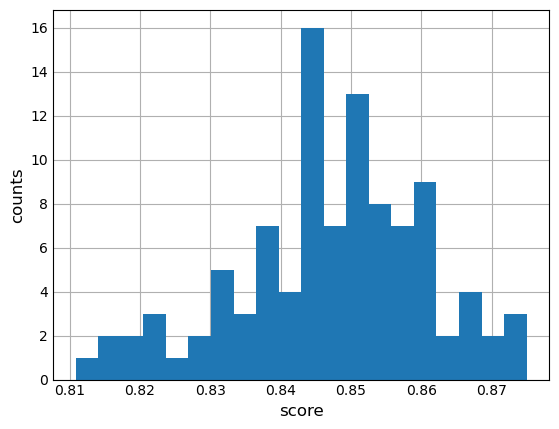

In [137]:
plt.hist(bart_evaluated_with_bertscore["f1"], bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

In [15]:
def summarize_abstractively_thesis(tokenizer, summarizer, law, max_token_number):
  chunk = []
  summarized = []

  for para in law:
      chunk_length = len(tokenizer.tokenize(' '.join(chunk)))
      para_length = len(tokenizer.tokenize(para))
      chunk_and_para_length = chunk_length + para_length

      if para_length > max_token_number:
        para = summarize_long_para(para, tokenizer, summarizer, max_token_number)
        summarized_long_para_length = len(tokenizer.tokenize(para))
        chunk_and_para_length = chunk_length + summarized_long_para_length

      if chunk_and_para_length > max_token_number: 
        summarized_chunk_text = summarize_para(' '.join(chunk), summarizer)
        summarized.append(summarized_chunk_text)
        print(chunk_length)
        chunk.clear()

      chunk.append(para)

  if chunk:
    chunk_text = ' '.join(chunk)
    chunk_length = len(tokenizer.tokenize(chunk_text))
    summarized_remaining_chunk_text = summarize_para(chunk_text, summarizer)
    summarized.append(summarized_remaining_chunk_text)

    print("summarized remaining chunk with length: ", chunk_length)
    chunk.clear()

  summarized_law_text = ' '.join(summarized)

  return summarized_law_text

In [77]:
thesis = """
Despite the abundance of solutions for text summarization, including extractive and abstractive methods, supervised and unsupervised techniques, etc., automatic text summarization remains one of the hardest tasks for a computer. Currently, no official model achieves high data-independent accuracy, with state-of-the-art models using deep learning typically reaching around 50% accuracy. This complexity arises from several key challenges:
Fusion of reading comprehension and text generation: Effectively summarizing text requires a comprehensive understanding of the content coupled with the ability to generate concise summaries. 
Representation of sentence significance and terms: To create a coherent and informative summary, it is crucial to capture the significance of each sentence and the terms within it as well as understand the inter-word and inter-sentence dependencies.
Limited focus on non-extractive methods: While human-generated summaries are typically abstractive in nature, most research in text summarization has predominantly focused on extractive methods. My prior research project also considered extractive algorithms. Extractive summarization refers to the process of choosing and reorganizing already existing sentences, whereas abstractive summarization focuses on creating fresh sentences that capture the main points of the text. Due to this bias, the performance of deep learning models, which have shown promise in other domains, may not be fully explored in the context of automatic text summarization.
Domain-specific language challenges: Applying domain-general summarization techniques to domain-specific documents may not yield optimal results due to the unique characteristics of domain-specific language. Legal texts that were chosen for this research, often have specific terminology, complex sentence structures, and precise formulations, which require specialized approaches to capture their essence accurately. Although some legal domain-specific methods have been developed for case document summarization, there is still a lack of comprehensive analyses comparing the performance of different summarization models on legal documents.
Limited exploration of transformer-based models: The field of document summarization has seen rapid advancements in recent years, largely driven by transformer-based models. However, to my knowledge, there has been limited exploration of how these state-of-the-art transformer-based summarization models perform on legal documents. Furthermore, no research has specifically applied summarization models to laws, highlighting a significant research gap in this area.
Lack of large legal summarization datasets: Acquiring datasets for legal summarization tasks is often expensive and a challenge on its own. Hiring legal domain experts to write summaries can be cost-prohibitive, resulting in small or non-existent datasets. This limitation makes it difficult, if not impossible, to utilize supervised models effectively. Additionally, legal documents and their summaries tend to be much longer than other document types, posing further challenges in summarization. 
Input capacity limitations: Using existing abstractive summarizers on legal documents presents a key challenge due to their often lower input capacity compared to the length of legal texts. Legal documents can be extensive, exceeding the limitations of many summarization models. 
For this research, I curated a dataset consisting of only 102 law-summary pairs from publicly available Ukrainian legislation to mimic the real-world scenario of summarizing long domain-specific documents. The dataset I used is notably smaller than the well-known CNN/Daily Mail benchmark, yet it comprises significantly longer documents and summaries.
I aim to contribute to the field of automatic text summarization, particularly in the context of laws and codes by exploring the effectiveness of state-of-the-art abstractive summarization models in this specific domain, addressing the challenges that arise.
The primary contributions of this work are: 
An analysis of the role of zero-shot learning in the summarization of domain-specific laws. 
Introduction of a new summarization dataset that can be utilized by the research community. 
Abstractive summarization is an advanced technique in natural language processing that aims to generate summaries that are more human-like by comprehending and interpreting the crucial elements of a text. Unlike extractive summarization, which selects and rearranges existing sentences, abstractive summarization involves creating new sentences and inferring the overall meaning of the text. This makes it more intricate and computationally intensive.
Summaries are frequently produced using abstractive summarization. Sequence-to-sequence models with attention mechanisms, copy mechanisms, content selection, pointer-generator methods, and reinforcement learning are common techniques used in abstractive summarization algorithms.
These techniques have shown promising performance in high-resource large summarization datasets, typically consisting of short documents.
However, real-world applications often face limitations in terms of resources. Obtaining domain-specific datasets, especially for lengthy documents containing thousands of tokens, which is also a more practical and relevant problem on its own, is a costly and time-consuming process. 
In contrast to the news summarization datasets like CNN/Daily Mail and XSUM, such texts as laws are significantly longer, adhere to specific structures, and incorporate more technical terms and complex concepts. 
As a result, researchers and industry professionals are exploring methods that require less annotated data. One such approach gaining attention is zero-shot learning, which leverages pre-trained models that have been trained on extensive amounts of data. This approach shows promise in eliminating the data annotation requirements in summarization tasks, offering a more practical and relevant solution.
Zero-shot learning is a powerful technique that has found applications in various fields, including computer vision and natural language processing (NLP). It refers to a scenario where the objective is to train a classifier using a labelled dataset enabling it to classify objects from unseen classes. 
One of the applications of zero-shot learning in NLP is text summarization. Zero-shot text summarization is often a powerful and underrated task. Off-the-shelf models can predict the content of a given text without explicit training on specific classes. 
Zero-shot summarization involves the use of pre-trained language models, making it a form of transfer learning. As stated in the literature, “A major assumption in many machine learning and data mining algorithms is that the training and future data must have the same features and the same probability distribution. However, in many real-world applications, this assumption may not hold. For example, we sometimes have a classification task in one domain of interest, but we only have sufficient training data in another domain of interest. In such cases, knowledge transfer, if done successfully, would greatly improve the performance of learning by avoiding much expensive data labelling efforts.”
The approach is particularly valuable when labelled data is scarce. In recent years, transfer learning from unsupervised models has enabled surpassing benchmarks on downstream supervised learning tasks. OpenAI's preprint on the GPT-3 model, boasting 175 billion parameters, demonstrates its competitive performance on downstream tasks with significantly less task-specific data compared to smaller models. Nevertheless, such large models remain impractical for real-world use.
Smaller models like BERT have been shown to encode an immense amount of information in their weights, making them suitable for downstream tasks that benefit from this latent information. These models can generate high-quality summaries without requiring a large amount of task-specific annotated data. The Big Science Research Workgroup , recently released their T0pp model, specifically trained for zero-shot multitask learning, which has outperformed models six times larger on the BIG-bench  benchmark and even outperformed GPT-3 (which is 16 times larger) on various NLP benchmarks.
Zero summarization is an emergent feature observed in large language models, typically appearing in models with 100 million parameters or more. The effectiveness of a model in zero-shot tasks tends to increase with model size, implying that larger models (with more trainable parameters or layers) generally perform better at this task.
In this research, zero-shot models trained for text summarization on news articles and internet data are employed to evaluate and compare the performance of advanced neural network text summarization models against simple baselines, specifically in the context of laws. State-of-the-art NLP models are utilized for text summarization in the legal domain, where large, annotated training sets are not readily available. Although transfer learning may not result in optimal performance, it can be an effective approach when limited data is available for the target task. However, it is important to note that these models are primarily designed to summarize news articles and internet content effectively, which may present challenges when applied to the specific patterns and complexities inherent in laws. While fine-tuning a pre-trained model on laws and their summaries may be ideal, it may still be possible to generate summaries that capture the main ideas and important information contained within the documents.
The field of natural language processing (NLP) has undergone a significant revolution with the introduction of Transformers.
This journey from recurrent neural networks (RNNs) and convolutional neural networks (CNNs) to Transformers marks a major milestone that took more than three decades to accomplish. Since then, dedicated research teams pushed the boundaries even further, transitioning from task-specific Transformers to multi-task models requiring minimal or no fine-tuning. Google's research team further standardized Transformers, by introducing a common input format that incorporates a prefix indicating the specific NLP problem to be solved, which in itself is a remarkable achievement.
The groundbreaking paper by Google, "Attention is All You Need", introduced Transformer models and demonstrated that attention mechanisms can effectively replace sequence models like LSTM leading to improved performance. Previous sequence processing models, such as RNNs, faced challenges in capturing long-term dependencies and suffered from computational inefficiency. Transformers address these issues by employing attention mechanisms instead of recurrence, enabling them to capture long-range dependencies and learn word relationships in a sentence while parallelizing computations. Consequently, Transformers can be trained on unprecedentedly large datasets that were previously unfeasible, offering a more accurate understanding of sentence meaning compared to traditional methods.
The current state-of-the-art in NLP comprises a diverse range of Transformer-based models that have significantly advanced the field. Prominent models like BART, T5, and Pegasus exemplify the cutting-edge capabilities of Transformers, delivering impressive results and inspiring further research and development in the field.
To fine-tune Transformer models for specific tasks, such as summarization, the Transformer architecture can be employed alongside different summarization datasets. These datasets typically include two essential features: the article itself and the highlights, which capture the key elements of the text and prove valuable for summarization.
Working extensively with real-life data is of great significance as it reveals the limitations that Transformers and other NLP models encounter when processing texts such as laws. It is crucial to present not only the successful samples but to acknowledge, that despite the transformative impact of Transformers, they have not solved all the NLP challenges we face. aptly titled their approach to T5 as "Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer", recognizing the ongoing exploration of the boundaries and potential of transfer learning in NLP.
Most abstractive summarization models have a limited input token capacity, which is usually shorter than the length of laws and codes. Ongoing research aims to develop models that can process larger sequences while minimizing resource consumption. For example, some models are highly optimized to handle a high number of tokens:
Big Bird attempts to address long document summarization by replacing the full self-attention of Transformer models with a sparse attention mechanism that can scale to longer inputs. However, this approach may struggle to scale to documents of arbitrary length and does not fully utilize the underlying structure of documents.
Longformer and Reformer are models that have been developed to efficiently process long input sequences for tasks including long document summarization. Longformer uses a combination of local and global attention to capture both local and long-range dependencies, while Reformer utilizes a reversible architecture and locality-sensitive hashing to reduce memory consumption and computational complexity.
Despite their advancements in handling long document summarization, Longformer’s sliding window attention still has a quadratic complexity with respect to the window size, which limits its ability to handle very long sequences. Additionally, Longformer requires pre-training on a large corpus of long documents, which is computationally expensive and may not be feasible for some domains. Reformer’s locality-sensitive hashing technique introduces the possibility of errors in the attention computation as it relies on random projections to group similar tokens. Furthermore, Reformer may face limitations in capturing fine-grained dependencies across very long documents, as it attends to only a fixed number of tokens per bucket. Both models might encounter difficulties when processing documents of arbitrary length. 
The "Divide and Conquer" approach is widely regarded as the best practice. This involves chunking the data and setting the maximum length as a reference, with the possibility of iterative chunking until the desired summary length is achieved.
Moreover, OpenAI recently published impressive work demonstrating how they combined reinforcement learning with human feedback to summarize entire books. This innovative technique showcases the potential of leveraging both automated learning algorithms and human expertise in generating high-quality summaries.
To address the low resource setting, I use pre-trained language models. Unlike previous approaches that rely on data augmentation techniques to handle data scarcity in summarization, my method needs no synthetic data augmentation. Moreover, I study a significantly more resource-constrained scenario — a complex law dataset with only 102 available (document, summary) pairs; assumes access to 90,000 pairs, uses 370 pairs.
I employ T5, Pegasus and BART models, which are recognized as state-of-the-art abstractive methods. These models are pre-trained on large datasets from related domains and can generate high-quality summaries without requiring additional training data. I access these models through the HuggingFace  library.
T5, also known as The Text-to-Text Transfer Transformer, is a type of Transformer that can be trained on various tasks using a unified architecture. It was developed by Google AI and introduced in the paper “Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer“. For this research, I use an mT5 model which is a fine-tuned pre-trained multilingual T5 on the XL-SUM dataset. It was finetuned on the 45 languages included in the XL-Sum dataset, which comprises 1 million professionally annotated article-summary pairs from BBC.
Pegasus is a transformer-based model for text generation, also developed by Google Research. It was introduced in the paper "PEGASUS: Pre-training with Extracted Gap-sentences for Abstractive Summarization", published in 2020. Pegasus is specifically designed for abstractive text summarization and was trained on the C4 (Colossal and Cleaned version of Common Crawl) web archive and HugeNews corpus of the articles, which consists of 1.5 million documents.
BART, developed by Facebook, stands for Bidirectional Auto-Regressive Transformer. It combines a standard Seq2Seq bidirectional encoder (similar to BERT) with a left-to-right autoregressive decoder (similar to GPT) into a single Seq2Seq model. In other words, BART = BERT + GPT. The BART-based Transformer was trained on the CNN/DailyMail dataset, which includes over 300,000 unique news articles, for finetuning it to text summarization.
Since the models were trained on short documents, they truncate documents longer than 512 or 1024 subwords which is much smaller than the number of subwords in law documents from my dataset.
To overcome this limitation, I adopt a chunking-based approach. Instead of feeding the entire source document as input, I split long laws and codes into smaller chunks, each consisting of no more than 510 tokens. I choose 510 tokens to leave room for possible [CLS] and [SEP] tokens. The BART model can take up to 1024 tokens, but I wanted to cut it to less than 1024 to be on the safe side. 512 should be better and it's what the original BERT uses, so it shouldn't be bad.
During the iteration, I do not break the sentences but collect them in chunks to preserve the context better. For each sentence, I count the number of tokens using the corresponding tokenizer for the model being used. If, at a certain iteration, adding the current sentence to the chunk would potentially exceed the 510 token limit, I summarize the chunk, append it to the final summary, clear the chunk, and start a new chunk with the current sentence.
There even happened to be sentences with several times more than 510 tokens. 
In these cases, I split such a long sentence into such number of parts so that each part does not exceed the 510 limit. I then summarize each part and check if the number of tokens of the already previously collected chunk and these generated summaries in total exceeds the 510 limit. If it exceeds, I summarize the previously collected chunk, append it to the final summary, and then append the summarized halves to the final summary. If it does not exceed, I simply add the two generated summaries from the halves to the chunk and continue the iteration. Ultimately, all the generated summaries are concatenated into a single final summary.
For the abstraction stage, I employ black-box pre-trained abstractive summarizers trained on related domains. Leveraging pre-trained language models and models trained on related domains helps improve generalization to unseen but related domains, such as laws.
This chunking-based approach has significant potential for broader applications in summarizing long documents.
In this research, I aligned 102 original laws and codes with their corresponding expert abstracts and automatically generated summaries. To obtain the data, I utilized an online version of Ukrainian legislation translated into English. The Ukrainian Parliament has made efforts to provide an English version of Ukrainian laws to promote understanding among non-Ukrainian speakers . However, out of the thousands of laws, only 173 have been translated into English. Additionally, the Parliament has provided abstracts for some laws to make them more accessible. Manual summarization of legal documents is a time-consuming task that requires extensive effort and strong legal knowledge. Consequently, only 102 laws out of the translated ones have corresponding abstracts. Thus, the automation of law document summarization would be highly beneficial.
I utilized a requests-HTML Python library  to fetch, navigate and extract the required data from the pages. The process involved the following steps:
Navigating to the List of Official Translations of Laws in English  and using the .page-link:not([title='current page']) CSS selector to obtain the remaining links from the pagination.
Making queries using all the pagination links to obtain links to the law pages through the .valid selector.
Scraping and saving the HTML content of each standardized law. I set a sleep time of 10 seconds for each law webpage to allow the JavaScript to load content dynamically. To identify links to the abstract pages, I used the [title='Abstract'] selector. If a link was found, I saved it and made a request to scrape its HTML content. If no link was found, it indicated that the law did not have an abstract, rendering it unsuitable for this study. 
Although some laws exhibited inconsistencies in their presentation and structure, deviating from the majority, I mitigated this issue by leveraging the HTML structure of law pages, which accompany references and amendments with the em HTML tag. In particular, I used the .rvts0 > .rvps8, .rvps2, .rvts0 .rvts15 selector to retrieve only meaningful information from standardized laws. This information included the title of the act, main content, and additional contextual details such as the author and date of entry into force.
For abstract webpages, I used the .rvts0 [align='justify'], .rvts0 ul selector to retrieve their content. Regarding the actual content of the abstracts, I concatenated the list items of the unordered lists into single sentences. This approach ensures greater lexical correctness when evaluating both human summaries and auto-generated summaries.
Measuring the performance of a model is often straightforward in many ML projects, where there is little ambiguity in determining the correctness of the model's results. The labels in the dataset are usually binary (True/False, Yes/No) or categorical, allowing for easy comparison between the model's output and the labels.
However, evaluating text generation becomes more challenging. The summaries provided in the dataset represent only one way to summarize the text, but there are numerous possibilities for summarization. Even if the model's output doesn't match a label exactly, it can still produce a valid and useful summary.
The most straightforward way to evaluate the quality of a summary is through human evaluation. Human evaluation is widely considered the gold standard in text summarization. Experts in automatic text summarization emphasize that domain expertise is a crucial factor contributing to the evaluation.
The evaluation of summaries by humans has the obvious drawback of being a time-consuming process. To address this challenge, Lin introduced Recall-Oriented Understudy for Gisting Evaluation (ROUGE) which became the most popular summarization evaluation metric. ROUGE compares the candidate summary to a set of human-produced reference summaries by computing the co-occurrences of n-grams between the candidate and each reference. In this research, I report the most prevalent in the literature.
A common practice is to calculate the average of all the ROUGE metrics mentioned above.
One drawback of ROUGE is that it is designed to compare a candidate against a set of reference summaries. However, in practice, it is rare to have multiple summaries for a single text.
While ROUGE performs well when averaged over a set of references, it struggles to distinguish between good and bad summaries when there is a single reference.
ROUGE relies on n-gram statistics, resulting in a surface-level comparison that penalizes lexical and compositional diversity, even if the output is semantically analogous to the reference. Supervised summarization methods tend to perform better on ROUGE scores compared to unsupervised approaches because they tend to have the same writing style as the reference summary. Recent approaches have investigated the use of word embeddings to analyze the semantic similarity between two texts. 
In this research, ROUGE is considered a necessary but not sufficient condition, where high scores do not necessarily indicate strong summaries, but low scores serve as a red flag.
Another automatic evaluation metric for text generation is BERTScore, which computes a similarity score for each token in the candidate sentence compared to each token in the reference sentence. BERTScore leverages the pre-trained contextual embeddings from BERT to automatically evaluate two texts by comparing the weighted cosine similarities of their embedded representations. Additionally, BERTScore computes precision, recall, and F1 measure metrics, as shown in 
In a previous research project, I established a baseline using random and extractive methods without employing ML techniques. Establishing a baseline is a critical step in any ML project as it allows us to quantify the progress achieved through the use of AI and determine whether investing in AI technology is worthwhile.
During the experimentation, I conducted tests with various output length limits and subjectively determined that 7 sentences for extractive methods and a maximum of 256 tokens for abstractive methods yielded the best results. These settings also resulted in compression rates approximately equal to those of human summaries. All other settings were kept as default.
It is important to note that these numbers are quite impressive for such a simple approach, particularly the ROUGE-1 and ROUGE-1 scores. To gain further context, we can refer to Pegasus Models , which displays scores of state-of-the-art models for different datasets.
It is important to note that certain contextual embedding models, such as RoBERTa, tend to produce BERTScores within a narrow range. In the provided example, the scores range approximately between 0.81 and 0.87. Although this may impact readability, it does not affect the ranking capability of BERTScore. If desired, the scores can be adjusted using baseline rescaling to achieve a wider spread.
In order to further enhance the research, several potential avenues for future experiments can be explored:
Investigating New Architectures: Exploring new architectures designed to handle longer sequences, such as Longformer, Reformer, Big Bird, and Linformer, could provide valuable insights into their effectiveness for summarizing laws and codes.
Expanding Automatic Evaluation Metrics: Incorporating additional automatic evaluation metrics can offer a more comprehensive assessment of the summarization models' performance. This can provide a broader perspective on the quality and effectiveness of the generated summaries.
Dataset Split for Fine-tuning: Splitting the existing dataset of 102 law and summary pairs into training and test sets would enable the opportunity to perform fine-tuning on this limited dataset. This could potentially improve the model's performance by training it specifically on the available data.
Scraping Ukrainian Laws and Summaries: Considering the availability of a larger number of laws and summaries in Ukrainian, scraping laws and their corresponding summaries in the Ukrainian language can be valuable. This would allow for the fine-tuning of multilingual models using the expanded dataset, potentially enhancing the summarization capabilities across different languages.
This research project demonstrated the potential of pre-trained zero-shot text summarization models in summarizing text within a narrow domain. By leveraging large-trained models from transformers, it was possible to generate informative and concise summaries of laws and codes.
The findings highlight the importance of exploring and monitoring the advancements in zero-shot summarization techniques. These models provide a valuable tool for summarizing text in various domains, including legal texts. By utilizing the knowledge and capabilities encoded in the pre-trained models, researchers and practitioners can efficiently generate summaries without the need for extensive domain-specific training data.
State-of-the-art models such as T5, Pegasus, and BART demonstrated promising results, achieving competitive ROUGE scores. These results highlight the potential of advanced neural architectures for law summarization and signify the progress made in the field. 
Furthermore, the findings underscore the importance of using appropriate evaluation metrics to assess summarization models. While ROUGE scores provide valuable insights, the inclusion of additional metrics such as BERTScore offers a more comprehensive evaluation, considering factors like semantic similarity.
Notably, the BART model emerged as the top performer for summarizing laws and codes. Its consistent and impressive performance surpassed that of the extractive and abstractive methods, generating accurate and meaningful summaries. The correlation observed between the ROUGE scores and BERTScore further validates its reliability and effectiveness.
"""

In [71]:
from nltk.tokenize import sent_tokenize

In [135]:
sumarized_thesis = summarize_abstractively_thesis(bart_tokenizer, bart_summarizer, sent_tokenize(thesis), 894)
sumarized_thesis

888
890
882
890
886


Your max_length is set to 256, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


888
summarized remaining chunk with length:  160


'No official model achieves high data-independent accuracy, with state-of-the-art models using deep learning typically reaching around 50% accuracy. Effectively summarizing text requires a comprehensive understanding of the content coupled with the ability to generate concise summaries. Legal texts often have specific terminology, complex sentence structures, and precise formulations, which require specialized approaches. Researchers and industry professionals are exploring methods that require less annotated data. One such approach gaining attention is zero-shot learning, which leverages pre-trained models that have been trained on extensive amounts of data. This approach shows promise in eliminating the data annotation requirements in summarization tasks, offering a more practical and relevant solution. Transformers can be trained on unprecedentedly large datasets that were previously unfeasible. The current state-of-the-art in NLP comprises a diverse range of Transformer-based model

In [97]:
final_abstract = summarize_abstractively_thesis(bart_tokenizer, bart_summarizer, sent_tokenize(sumarized_thesis), 1024)
final_abstract

summarized remaining chunk with length:  378


'No official model achieves high data-independent accuracy, with state-of-the-art models using deep learning typically reaching around 50% accuracy. Legal texts often have specific terminology, complex sentence structures, and precise formulations. By leveraging large-trained models from transformers, it was possible to generate informative and concise summaries of laws and code.'